In [1]:
import pandas as pd
import numpy as np

from config import CSV_FILE_URL
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.model_selection import FeatureImportances
from sklearn.feature_selection import SelectFromModel

## Read Data

In [2]:
df = pd.read_csv(CSV_FILE_URL)
df.shape

(284807, 31)

## Clean Data

In [3]:
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Exploration

In [4]:
df.groupby('Class').count()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315,...,284315,284315,284315,284315,284315,284315,284315,284315,284315,284315
1,492,492,492,492,492,492,492,492,492,492,...,492,492,492,492,492,492,492,492,492,492


<AxesSubplot:xlabel='Class'>

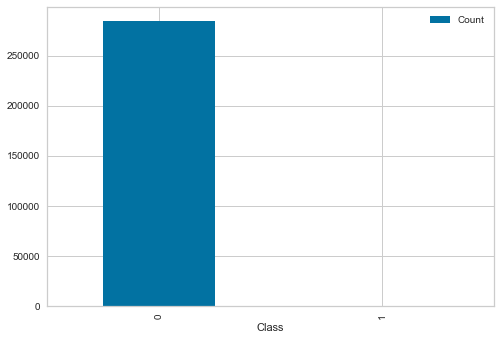

In [5]:
grouped_df = df[['Class','Time']].groupby('Class').count()
grouped_df = grouped_df.rename(columns={"Time":"Count"})
grouped_df.plot(kind="bar")

It is evident from the above plot that data is highly imbalanced. The dataset has only 492 fraudulent transactions out of a total of 284,807 transactions, which is a mere 0.17%.